Задача состоит в прогнозировании ноты по n предшествующим. Формат входных данных: midi.
(подробнее о формате http://www.music.mcgill.ca/~ich/classes/mumt306/StandardMIDIfileformat.html#BM0_)
Для анализа была выбрана база лютеранской церковной музыки (англ. Lutheran chorale) И. С. Баха:
https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi
Эти произведения отличаются простотой мелодии в рамках одного голоса: общий диапозон мелодии для одного инструмента не превышает октавы, все ноты играются строго последовательно, мелодия стротися на 4-7 нотах.

Для обучения модели было выбрано 450 файлов, модель тестировалась на 50 файлах. Модели строились при различных значениях n (количества нот для анализа). Алгоритм из файла CyberBach.py обучает и тестирует модель, выводит логи с указанием имени модели, числа n, доли угаданных нот, доли ошибок на один тон, среднеквадратичной ошибки в тонах.

Для решения по условию используется линейная модель. Особенность этой регресионной задачи состоит в том, что множество ответов -- это подмножество целых чисел. В самом деле, в европейской теории музыки инструменты настраивают в равномерно темперированный строй (этот строй используется и в формате midi): интервал "октава" делится на 12 элементарных музыкальных интервалов -- полутонов. Поэтому даже если модель предсказывает ответ, являющийся дробным числом полутонов, его приходится округлять до ближайщего целого (ср. кв. ошибка считается без округления). 

Для работы с midi-файлами была использована следующая библиотека:
https://github.com/vishnubob/python-midi

Библиотека для обучения моделей:
http://scikit-learn.org/stable/index.html

В качестве признаков были выбраны частоты n предыдущих нот. Следующая нота предсказывалась как их линейная комбинация. Обучение проводилось методом наименьших квадратов и с помощью оценочной функции Тейла – Сена. Необходимость применения последнего метода обусловлена тем, что при использовании n предыдущих нот неизбежно возникали выборки, где в эти n нот попадали завершенная и только что начатая музыкальная фраза. Такие случаи можно считать "грязными" данными. 

Загружаем результаты тестирования линейной модели из логов:

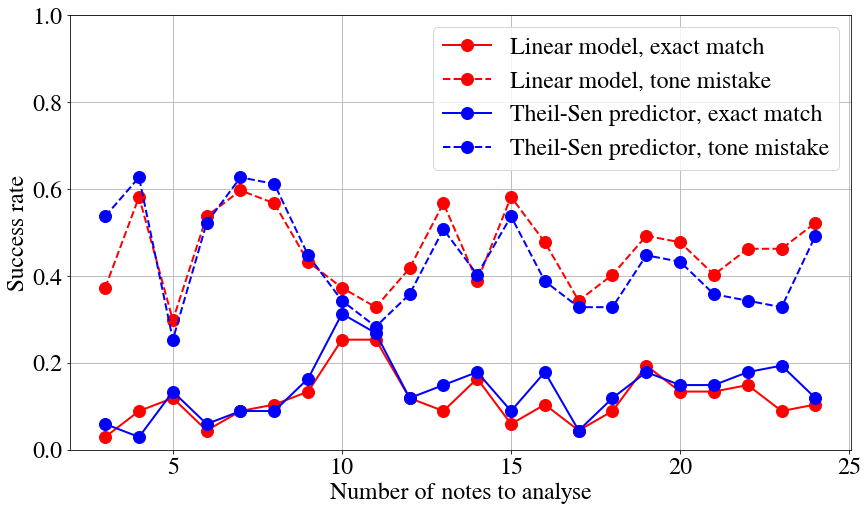

In [10]:
from matplotlib import pylab
from numpy import arange
import ast
n = []
success_rate = []
tone_error = []
errors = []
Model_name = []
with open('logfile.txt', 'r') as f:
  for i, line in enumerate (f):
    if line[0].isalpha():
        Model_name.append(f)
    else:
        for j, s in enumerate (line.split(' ')):
            if j == 0 and s not in n:
                n.append(s)
            if j == 1: 
                success_rate.append(s)
            if j == 2:
                tone_error.append(s)
            if j == 3:
                errors.append (s)
n.remove("\n")
errors = [x.replace('\n', '') for x in errors]
n = [float(x) for x in n]
success_rate = [float(x) for x in success_rate]
tone_error = [float(x) for x in tone_error]
errors = [float(x) for x in errors]
pylab.rcParams['font.family'] = 'serif'
pylab.rcParams['font.serif'] = 'FreeSerif'
pylab.rcParams['lines.linewidth'] = 2
pylab.rcParams['lines.markersize'] = 12
pylab.rcParams['xtick.labelsize'] = 24
pylab.rcParams['ytick.labelsize'] = 24
pylab.rcParams['legend.fontsize'] = 24
pylab.rcParams['axes.titlesize'] = 36
pylab.rcParams['axes.labelsize'] = 24
pylab.rcParams["figure.figsize"] = [14,8]
pylab.plot (n, success_rate[0:len(n)], '-ro', label = "Linear model, exact match")
pylab.plot (n, tone_error[0:len(n)], '--ro', label = "Linear model, tone mistake")
pylab.plot (n, success_rate[2 * len(n): 3 * len(n)], '-bo', label = "Theil-Sen predictor, exact match")
pylab.plot (n, tone_error[2 * len(n):3 * len(n)],'--bo', label = "Theil-Sen predictor, tone mistake")
pylab.ylim ([0, 1])
pylab.legend(loc = 1, prop = {'size' : 24})
pylab.xlabel ("Number of notes to analyse")
pylab.ylabel ("Success rate")
pylab.grid()

Сплошной линии на графике соответсвует зависимость доли удачных прогнозов (с учётом округления) от длины анализируемого сегмента. Пунктирная линия представляет аналогичную зависимость для доли прогнозов с ошибкой в один тон. Примечательно, что 10 является оптимальным количеством анализируемых нот. Возможно, это средняя длина музыкальной фразы в начале каждого произведения.

Для увеличения вероятности успешного прогноза был введён дополнительный признак, учитывающий частоту вхождения различных комбинаций с последней доступной для анализа нотой. Например, в первом произведении из базы встречаются подряд ноты:
GGDBAGGAB**A** (соль-соль-ре-си-ля-соль-соль-ля-си-ля, n = 10). Последняя нота А; при помощи суффиксного дерева (https://pypi.org/project/suffix-trees/) строится частотная таблица для сочетаний A со всеми нотами, ранее встречавшимися в мелодии. В данном случае AG (1), AB(1), выбирается любая из нот-кандидатов (G или B).
Посмотрим на прирост от такой модификации:

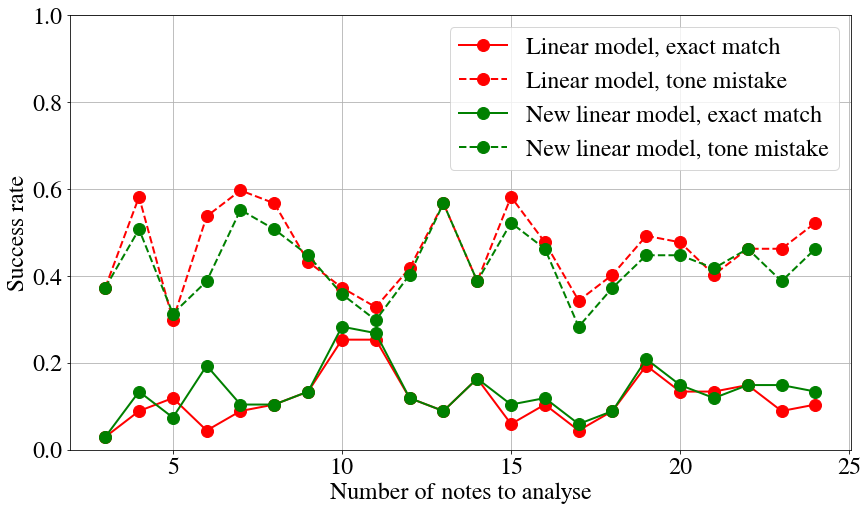

In [11]:
pylab.plot (n, success_rate[0:len(n)], '-ro', label = "Linear model, exact match")
pylab.plot (n, tone_error[0:len(n)], '--ro', label = "Linear model, tone mistake")
pylab.plot (n, success_rate[len(n):2 * len(n)], '-go', label = "New linear model, exact match")
pylab.plot (n, tone_error[len(n):2 * len(n)], '--go', label = "New linear model, tone mistake")
pylab.xlabel ("Number of notes to analyse")
pylab.ylabel ("Success rate")
pylab.grid()
pylab.ylim([0, 1])
pylab.legend(loc = 1, prop = {'size' : 24})

(0, 1)

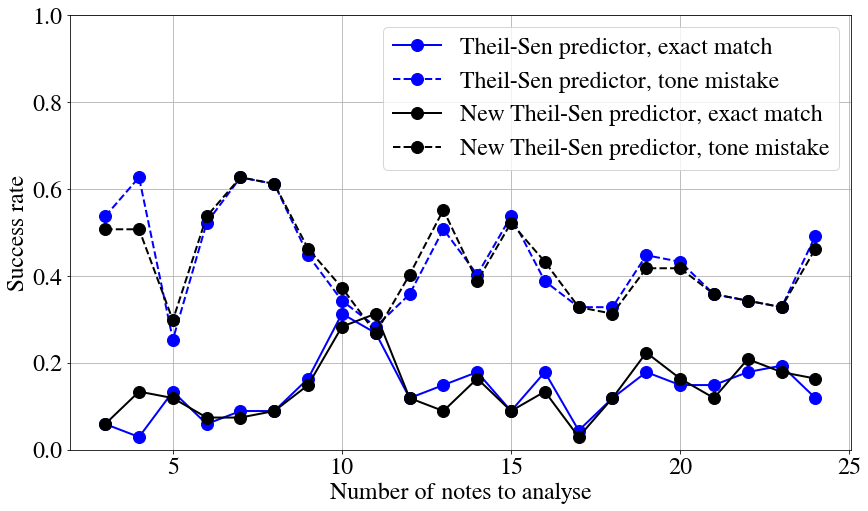

In [12]:
pylab.plot (n, success_rate[2 * len(n): 3 * len(n)], '-bo', label = "Theil-Sen predictor, exact match")
pylab.plot (n, tone_error[2 * len(n): 3 * len(n)], '--bo', label = "Theil-Sen predictor, tone mistake")
pylab.plot (n, success_rate[3 * len(n): 4 * len(n)], '-ko', label = "New Theil-Sen predictor, exact match")
pylab.plot (n, tone_error[3 * len(n): 4 * len(n)], '--ko', label = "New Theil-Sen predictor, tone mistake")
pylab.xlabel ("Number of notes to analyse")
pylab.ylabel ("Success rate")
pylab.grid ()
pylab.legend (loc = 1, prop = {'size' : 24})
pylab.ylim ([0, 1])

Модификация улучшила результаты линейной модели на 3 процента, у модели с оценочной функцией Тейла-Сена только изменилось оптимальное n. Для финальной оценки результатов можно построить графики для всех оценок, отличающихся от истинной не более, чем на тон.

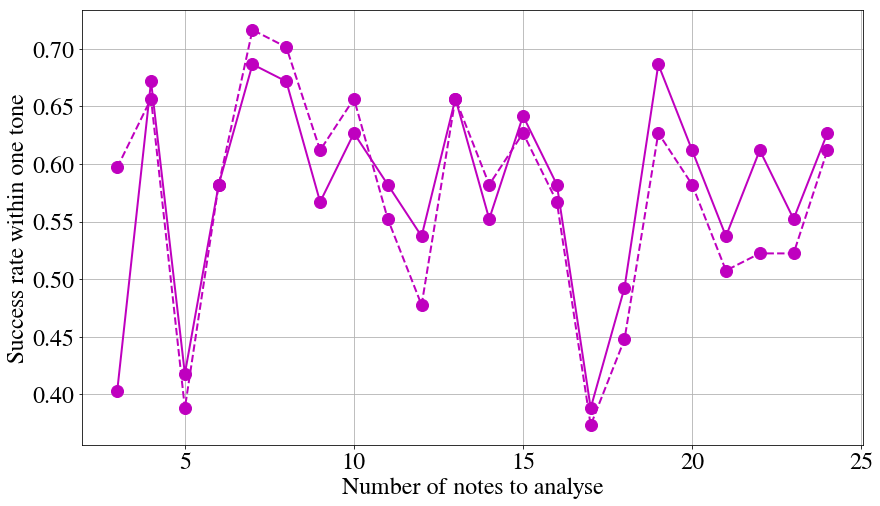

In [13]:
from operator import add
tone = list(map(add, success_rate, tone_error))
pylab.plot (n, tone[0:len(n)], "-mo")
pylab.plot (n, tone[2 * len(n): 3 * len(n)], "--mo")
pylab.xlabel ("Number of notes to analyse")
pylab.ylabel ("Success rate within one tone")
pylab.grid ()

На последнем рисунке представлены зависимости успеха оценки с отклонением не более одного тона от истинной ноты для линейной модели с методом наименьших квадратов и для модели с оценочной функцией Тейла-Сена. Если считать оценку с ошибкой в два полутона успешной, то удалось достичь вероятности "успешной" оценки в 72% при n = 7. Для точных оценок линейная модель непригодна.

Построим графики ошибки, требующиеся в задании-3.

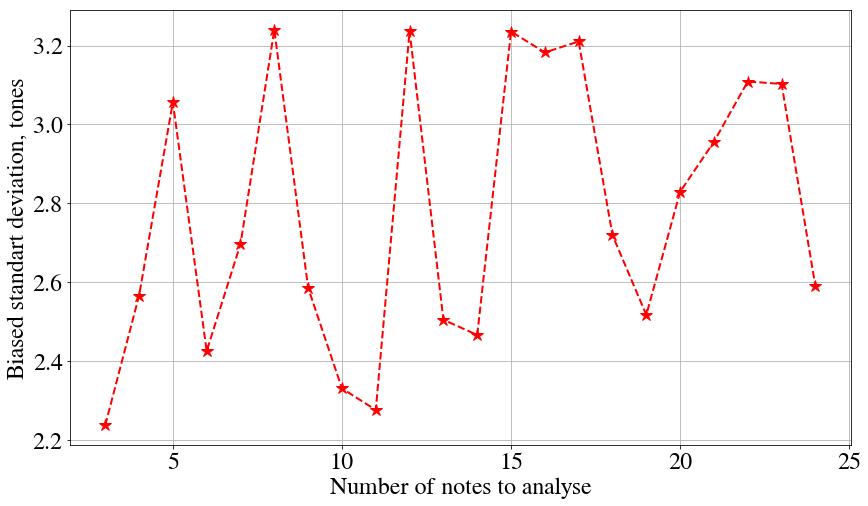

In [15]:
pylab.plot (n, errors[2 * len(n): 3 * len(n)], "--r*")
pylab.xlabel ("Number of notes to analyse")
pylab.ylabel ("Biased standard deviation, tones")
pylab.grid ()

Была предпринята попытка улучшить модель. Преобразование кода ноты в её символ теперь проводится с учётом октавы ноты. Использовался метод наименьших квадратов. Способ создания признаков был изменён: теперь для генерации признака "частота встречаемости комбинации" используются все n нот, в итоговую линейную комбинацию вместе с этой оценкой попадают только lin_n последних нот. Исследована зависимость успешного прогноза как функция n и lin_n, соответсвующие данные записаны в лог logfile_new.txt. Построим 3D график.

"\nnrows, ncols = 13, 15\ngrid = temp.reshape((nrows, ncols))\n\nplt.imshow(grid, extent=(new_n.min(), new_n.max(), .max(), y.min()),\n           interpolation='nearest', cmap=cm.gist_rainbow)\nplt.show()\n"

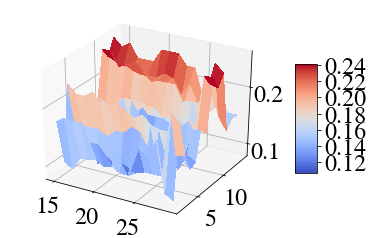

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.mlab import griddata
from matplotlib import cm

new_n = []
lin_n = []
new_success_rate = []
new_tone_error = []
new_errors = []
new_model_name = []
with open('logfile_new.txt', 'r') as f:
  for i, line in enumerate (f):
    if line[0].isalpha():
        new_model_name.append(f)
    else:
        for j, s in enumerate (line.split(' ')):
            if j == 0 and s not in new_n:
                new_n.append(s)
            if j == 1 and s not in lin_n: 
                lin_n.append(s)
            if j == 2: 
                new_success_rate.append(s)
            if j == 3:
                new_tone_error.append(s)
            if j == 4:
                new_errors.append (s)
new_n = [float(x) for x in new_n]
lin_n = [float(x) for x in lin_n]
new_success_rate = [float(x) for x in new_success_rate]
new_tone_error = [float(x) for x in new_tone_error]
new_errors = [float(x) for x in new_errors]

Z = np.zeros (shape = (13, 15))
for i in range (0, len (lin_n)):
    for j in range (0, len (new_n)):
        Z[i][j] = new_success_rate [13 * i + j]
X, Y = np.meshgrid(new_n, lin_n)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ind = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
'''
nrows, ncols = 13, 15
grid = temp.reshape((nrows, ncols))

plt.imshow(grid, extent=(new_n.min(), new_n.max(), .max(), y.min()),
           interpolation='nearest', cmap=cm.gist_rainbow)
plt.show()
'''

Наилучший результат достинается при n = 25 и lin_n = 4, 8, 9.